For better rendering of the DataFrames [view this notebook on nbviewer.org](https://nbviewer.org/github/klezm/QuantumAnnealingPlayground/blob/main/choosing_boxes_problem/choosing_boxes.ipynb)
or [open it on the D-Wave Leap IDE](https://ide.dwavesys.io/#https://github.com/klezm/QuantumAnnealingPlayground)

In [ ]:
import dimod

try:
    dimod.ExactCQMSolver
except:
    !pip install -U dwave-ocean-sdk dimod
    # !pip install pandas numpy sympy matplotlib tabulate
    import os
    os._exit(0)  # restarts the ipython kernel

# Choosing Boxes Problem

as shown in the [problem formulation guide (chapt. 4.4)](https://www.dwavesys.com/media/bu0lh5ee/problem-formulation-guide-2022-01-10.pdf).


- https://github.com/dwave-training/choosing-boxes

## Problem

Pick 2 Boxes and minimize the summed weight.

| Box   | Weight |
| ----- | ------ |
| $x_1$ | 15     |
| $x_2$ | 20     |
| $x_3$ | 25     |

QUBO:  

$$
\begin{align*}
\text{Objective:}\quad & min(15x_1 + 20x_2 + 25x_3) \\
\text{Constraint:}\quad & x_1 + x_2 + x_3 = 2
\end{align*}
$$

## Mathematical formulation

For $\gamma = 1$ (Lagrange Multiplier)

$$
\begin{align}
    & min
    (
        (15x_1 + 20x_2 + 25x_3)

        +\gamma
        {
            \underbrace{
                (x_1+x_2+x_3-2)^2
            }_{
                \underbrace{
                    x_1^2 
                    - 4 x_1 
                    + x_2^2 
                    - 4 x_2 
                    + x_3^2 
                    - 4 x_3 

                    + 2 x_1 x_2
                    + 2 x_1 x_3 
                    + 2 x_2 x_3 

                    + 4
                }_{
                    - 3x_1 - 3x_2 - 3x_3
                    + 2x_1x_2 + 2x_1x_3 + 2x_2x_3
                    + 4
                    \quad
                    (x_i^2 = x_i \ \text{with} \ x_i \in \{0,1\})
                }
            }
        }
    ) \\

    & = min
    \left(
        15x_1
        - 3x_1
        + 20x_2
        - 3x_2
        + 25x_3
        - 3x_3
        + 2x_1x_2
        + 2x_1x_3
        + 2x_2x_3
        + 4
    \right) \\ 

    & = min
    \left(
        \underbrace{
            12x_1
            + 17x_2
            + 22x_3
        }_{\text{linear terms}}
        +
        \underbrace{
            2x_1x_2
            + 2x_1x_3
            + 2x_2x_3
        }_{\text{quadratic terms}}
        + 4
    \right) \\

    & \Rightarrow
    Q = 
    \left(
        \begin{matrix}
            12  & 2  & 2 \\
                & 17 & 2 \\
                &    & 22 \\
        \end{matrix}
    \right)
\end{align}
$$

## Content

1. [BQM & CQM](#BQM-%26-CQM) - Just passing the QUBO to a solver and let it do the rest
   1. [Lagrange Multiplier (γ) Comparison](#Lagrange-Multiplier-%28%CE%B3%29-Comparison) - How does γ effect the QUBO?
2. [QUBO Matrix](#QUBO-Matrix) - Calculating the QUBO matrix from scratch and then passing it to a solver.

## BQM & CQM

We can use equation (1) to build a BQM or the objective & constraint functions to build a CQM.
Both can be used to solve the problem on a D-Wave QA.

[D-Wave Docs: Quadratic Models](https://docs.dwavesys.com/docs/latest/c_gs_workflow.html#quadratic-models)  
[D-Wave Docs: Problem Parameters](https://docs.dwavesys.com/docs/latest/c_solver_problems.html#bqm)

In [17]:
from IPython.display import Markdown
from pprint import pprint
from tabulate import tabulate

# from collections import defaultdict
import numpy as np
import pandas as pd
import sympy

import dwave.system
from dwave.system import DWaveSampler, EmbeddingComposite, LeapHybridCQMSampler
import dimod
# import dwave.inspector
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os

# print("DWAVE_API_TOKEN" in os.environ)
# print(os.environ.get("DWAVE_API_TOKEN"))
# # os.environ["DWAVE_API_TOKEN"] = "YOUR_API_TOKEN"
# print(os.environ.get("DWAVE_API_TOKEN"))

if "DWAVE_API_TOKEN" not in locals() or "DWAVE_API_TOKEN" not in os.environ:
    DWAVE_API_TOKEN = input("paste your D-Wave API token here:")
    os.environ["DWAVE_API_TOKEN"] = DWAVE_API_TOKEN

In [3]:
def bqm2matrix(bqm: dimod.BinaryQuadraticModel) -> np.ndarray:
    bqm_np = bqm.to_numpy_vectors()  # bqm.variables.to_serializable()
    bqm_m = np.diag(bqm_np.linear_biases)
    for ir, ic, b in zip(bqm_np.quadratic.row_indices, bqm_np.quadratic.col_indices, bqm_np.quadratic.biases):
        bqm_m[ir, ic] = b
    return bqm_m
# bqm2matrix(bqm)

### BQM

In [283]:
γ = 35
x1 = dimod.Binary("x1")
x2 = dimod.Binary("x2")
x3 = dimod.Binary("x3")

bqm = 15 * x1 + 20 * x2 + 25 * x3 + γ * (x1 + x2 + x3 - 2)**2
print(bqm, "\n")

BinaryQuadraticModel({'x1': -90.0, 'x2': -85.0, 'x3': -80.0}, {('x2', 'x1'): 70.0, ('x3', 'x1'): 70.0, ('x3', 'x2'): 70.0}, 140.0, 'BINARY') 



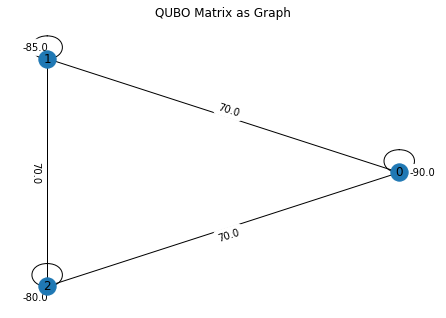

array([[-90.,  70.,  70.],
       [ 70., -85.,  70.],
       [ 70.,  70., -80.]])

In [81]:
# G = bqm.to_networkx_graph()
# nx.draw_networkx(G)

# G = nx.from_numpy_matrix(bqm.to_numpy_matrix(bqm.variables.to_serializable()))
G = nx.from_numpy_matrix(bqm2matrix(bqm))

pos = nx.circular_layout(G)
pos_labels = {k: v * 1.1 for k, v in pos.items()}

nx.draw(G, pos, with_labels = True)
nx.draw_networkx_edge_labels(
    G,
    pos_labels,
    # edge_labels = {e: G.edges[e]["bias"] for e in G.edges},
    edge_labels = {e: G.edges[e]["weight"] for e in G.edges},
)
plt.title("QUBO Matrix as Graph")
plt.show()

nx.to_numpy_array(G)

In [289]:
sampler_bqm = EmbeddingComposite(DWaveSampler())  # token = DWAVE_API_TOKEN
sampleset_bqm = sampler_bqm.sample(bqm, num_reads = 100, label = f'Choosing Boxes BQM (γ = {γ})')

sampleset_bqm_df = sampleset_bqm.to_pandas_dataframe()
# Reintroduce the offset to get the "real" energies (not the scaled ones)
sampleset_bqm_df["energy_no_offset"] = sampleset_bqm_df.energy - bqm.offset

display(sampleset_bqm_df.sort_values(by = "energy"))
print(str(sampleset_bqm).splitlines()[-1])

,x1,x2,x3,chain_break_fraction,energy,num_occurrences,energy_no_offset
0,1,1,0,0.0,35.0,78,-105.0
1,1,0,1,0.0,40.0,15,-100.0
2,0,1,1,0.0,45.0,6,-95.0
3,1,0,0,0.0,50.0,1,-90.0


['BINARY', 4 rows, 100 samples, 3 variables]


#### Exact Solver

In [ ]:
γ = 60
x1, x2, x3 = [dimod.Binary(f'x{i}') for i in range(1, 4)]
bqm = 15 * x1 + 20 * x2 + 25 * x3 + γ * (x1 + x2 + x3 - 2)**2
qvars = bqm.variables.to_serializable()

sampleset_bqm_exact = dimod.ExactSolver().sample(bqm)
# sampleset_bqm_exact = dimod.ExactDQMSolver().sample_dqm(bqm)
# sampleset_bqm_exact = dimod.ExactPolySolver().sample(bqm)

sampleset_bqm_exact_df = sampleset_bqm_exact.to_pandas_dataframe().assign(constraint_satisfied = lambda r: r.loc[:, qvars].sum(axis = 1) == 2)
display(sampleset_bqm_exact_df.sort_values(by = "energy"))
display(sampleset_bqm_exact_df.sort_values(by = qvars))
print(str(sampleset_bqm_exact).splitlines()[-1])

#### Eigenvalues Visualization

In [ ]:
def scale_cmap_log(cmap = plt.cm.gist_ncar, plot = False) -> plt.matplotlib.colors.LinearSegmentedColormap:
    """
    Scales a colormap logarithmically.
    """
    n = 10000  # number of samples from original colormap
    logs = np.geomspace(1, 256 + 1, n, dtype = int) - 1

    log_colors = [cmap(i) for i in range(n)]
    log_colors = [log_colors[i] for i in logs]

    cmap_log = cmap.from_list(cmap.name + "_log", log_colors, len(log_colors))

    if plot:
        plt.imshow([np.linspace(0, 1, 256)] , aspect = "auto", cmap = cmap_log)
        plt.gcf().set_size_inches(8.5, .5)
        plt.title("Logarithmic Colormap")
        plt.gca().yaxis.set_visible(False)
        plt.show()
    return cmap_log

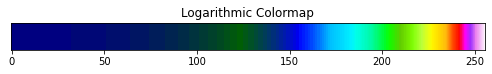

Here we can see ... TODO 

energy @,γ = 26,γ = 27,γ = 28,γ = 29,γ = 30,γ = 31,γ = 32,γ = 33,γ = 34
solution set,,,,,,,,,
2,-69,-73,-77,-81,-85,-89,-93,-97,-101
6,-64,-68,-72,-76,-80,-84,-88,-92,-96
1,-63,-66,-69,-72,-75,-78,-81,-84,-87
4,-59,-63,-67,-71,-75,-79,-83,-87,-91
3,-58,-61,-64,-67,-70,-73,-76,-79,-82
7,-53,-56,-59,-62,-65,-68,-71,-74,-77
5,-18,-21,-24,-27,-30,-33,-36,-39,-42
0,0,0,0,0,0,0,0,0,0


In [556]:
dfs = []
for γ in range(26, 35):
    x1, x2, x3 = [dimod.Binary(f'x{i}') for i in range(1, 4)]
    bqm = 15 * x1 + 20 * x2 + 25 * x3 + γ * (x1 + x2 + x3 - 2)**2
    qvars = bqm.variables.to_serializable()

    sampleset_bqm_exact = dimod.ExactSolver().sample(bqm)

    sampleset_bqm_exact_df = sampleset_bqm_exact.to_pandas_dataframe().assign(constraint_satisfied = lambda r: r.loc[:, qvars].sum(axis = 1) == 2)

    if True:  # Reintroduce the offset to get the "real" energies (not the scaled ones)
        sampleset_bqm_exact_df.energy -= bqm.offset
    # print(bqm.energies((dimod.reference.samplers.exact_solver._graycode(bqm), list(bqm.variables))) - bqm.offset)

    dfs.append([γ, sampleset_bqm_exact_df.sort_values(by = "energy")])

# display(pd.concat([x[1] for x in dfs], axis = 1, ).T.reset_index().set_index("index", append = True).T.style.background_gradient(subset = [(i, "energy") for i in [3, 9, 15]], cmap = "RdBu_r"))
# pprint(df.columns.get_locs([slice(None), "energy"]))
# pprint(df.columns.get_loc_level("energy", 1, drop_level = False)[1])
display(
    pd.concat(
        [x[1] for x in dfs],
        keys = [x[0] for x in dfs],
        axis = 1
    ).T.drop_duplicates(
    ).T.astype(
        int
    ).rename_axis(
        columns = ["γ", ""],
    ).style.background_gradient(
        subset = pd.IndexSlice[:, pd.IndexSlice[:, "energy"]],
        cmap = scale_cmap_log(plt.cm.gist_ncar, True).reversed(),
    )
)

display(Markdown("Here we can see ... TODO "))

display(pd.concat(
        [x.energy.rename(index = f'γ = {γ}') for γ, x in dfs],
        axis = 1
    ).rename_axis(
        index = "solution set",
        columns = "energy @",
    ).astype(
        int
    ).style.background_gradient(
        axis = None,
        cmap = scale_cmap_log(plt.cm.gist_ncar).reversed(),
    )
)

In [558]:
# Here: with added offset

    # Reintroduce the offset to get the "real" energies (not the scaled ones)
    # sampleset_bqm_exact_df.energy -= bqm.offset

energy @,γ = 26,γ = 27,γ = 28,γ = 29,γ = 30,γ = 31,γ = 32,γ = 33,γ = 34
solution set,,,,,,,,,
2,35,35,35,35,35,35,35,35,35
6,40,40,40,40,40,40,40,40,40
1,41,42,43,44,45,46,47,48,49
4,45,45,45,45,45,45,45,45,45
3,46,47,48,49,50,51,52,53,54
7,51,52,53,54,55,56,57,58,59
5,86,87,88,89,90,91,92,93,94
0,104,108,112,116,120,124,128,132,136


### CQM

CQM can be used with the `LeapHybridCQMSampler()`.
With the `ExactCQMSolver()` the problem can be solved without a QPU.

In [158]:
x1, x2, x3 = [dimod.Binary(f'x{i}') for i in range(1, 4)]

cqm = dimod.ConstrainedQuadraticModel()
cqm.set_objective(15 * x1 + 20 * x2 + 25 * x3)
cqm.add_constraint(x1 + x2 + x3 == 2, label = "pick exactly 2 boxes")

# pprint(vars(cqm)); print()
# pprint(vars(dimod.cqm_to_bqm(cqm)[0])); print()

sampler_cqm = LeapHybridCQMSampler()
# print(sampler_cqm.parameters, "\n")
sampleset_cqm = sampler_cqm.sample_cqm(cqm, label = f'Choosing Boxes CQM (γ = {γ})')

display(sampleset_cqm.to_pandas_dataframe().sort_values(by = "energy").convert_dtypes().style.background_gradient(subset = "energy"))
print(str(sampleset_cqm).splitlines()[-1])

,x1,x2,x3,energy,is_feasible,is_satisfied,num_occurrences
13,1,0,0,15,False,False,1
0,1,1,0,35,True,True,1
21,1,1,0,35,True,True,1
22,1,1,0,35,True,True,1
23,1,1,0,35,True,True,1
24,1,1,0,35,True,True,1
25,1,1,0,35,True,True,1
26,1,1,0,35,True,True,1
20,1,1,0,35,True,True,1
27,1,1,0,35,True,True,1


['INTEGER', 38 rows, 38 samples, 3 variables]


In [279]:
# pprint(vars(cqm))  # pprint(cqm.objective); print(cqm.constraints); pprint(cqm.discrete); pprint(cqm.variables)
# print(f'{cqm.check_feasible(sampleset_cqm.first.sample)     =  }')
# # for sample in sampleset_cqm.samples(): print(f'{cqm.check_feasible(sample)     =  }')
# pprint(list(cqm.iter_constraint_data(sampleset_cqm.first.sample)))
# # for sample in sampleset_cqm.samples(): pprint(list(cqm.iter_constraint_data(sample)))
# pprint(list(cqm.iter_violations(sampleset_cqm.first.sample)))
# # for sample in sampleset_cqm.samples(): pprint(list(cqm.iter_violations(sample)))
# print(f'{cqm.num_biases()                 =  }')
# print(f'{cqm.num_quadratic_variables()    =  }')
# pprint(cqm.violations(sampleset_cqm.first.sample))
# # for sample in sampleset_cqm.samples(): pprint(cqm.violations(sample))

# pprint(sampleset_cqm.info)
# sampleset_cqm.record
# list(sampleset_cqm.samples())
# dimod.as_samples(sampleset_cqm)
# pprint(dimod.cqm_to_bqm(cqm))

{'_constraints': {'pick exactly 2 boxes': BinaryQuadraticModel({'x1': 1.0, 'x2': 1.0, 'x3': 1.0}, {}, 0.0, 'BINARY') == 2},
 '_discrete': set(),
 '_objective': QuadraticModel({'x1': 15.0, 'x2': 20.0, 'x3': 25.0}, {}, 0.0, {'x1': 'BINARY', 'x2': 'BINARY', 'x3': 'BINARY'}, dtype='float64'),
 '_variables': Variables(['x1', 'x2', 'x3']),
 'discrete': set()}
cqm.check_feasible(sampleset_cqm.first.sample)     =  False
[ConstraintData(label='pick exactly 2 boxes', lhs_energy=1.0, rhs_energy=2, sense=<Sense.Eq: '=='>, activity=-1.0, violation=1.0)]
[('pick exactly 2 boxes', 1.0)]
cqm.num_biases()                 =  6
cqm.num_quadratic_variables()    =  0
{'pick exactly 2 boxes': 1.0}
{'charge_time': 4991796,
 'constraint_labels': ['pick exactly 2 boxes'],
 'problem_id': 'b5c2fa2a-123c-4427-ab7d-ab890408d414',
 'qpu_access_time': 8529,
 'run_time': 4991796}
(BinaryQuadraticModel({'x1': -735.0, 'x2': -730.0, 'x3': -725.0}, {('x2', 'x1'): 500.0, ('x3', 'x1'): 500.0, ('x3', 'x2'): 500.0}, 1000.0, 

#### Exact CQM Solver

In [43]:
x1, x2, x3 = [dimod.Binary(f'x{i}') for i in range(1, 4)]
# symbols = [x1, x2, x3]

cqm = dimod.ConstrainedQuadraticModel()
cqm.set_objective(15 * x1 + 20 * x2 + 25 * x3)
cqm.add_constraint(x1 + x2 + x3 == 2, label = "pick exactly 2 boxes")
qvars = cqm.variables.to_serializable()

# pprint(vars(cqm)); print()
pprint(vars(dimod.cqm_to_bqm(cqm)[0])); print()

sampleset_cqm = dimod.ExactCQMSolver().sample_cqm(cqm)

# print(sampleset_cqm)
# print(sampleset_cqm.to_pandas_dataframe().to_string())
display(sampleset_cqm.to_pandas_dataframe().sort_values(by = "energy"))
display(sampleset_cqm.to_pandas_dataframe().sort_values(by = qvars))
print(str(sampleset_cqm).splitlines()[-1])

{'_linear': {'x1': -735.0, 'x2': -730.0, 'x3': -725.0},
 'data': <dimod.binary.cybqm.cybqm_float64.cyBQM_float64 object at 0x0000020835F10940>,
 'get_linear': <built-in method get_linear of dimod.binary.cybqm.cybqm_float64.cyBQM_float64 object at 0x0000020835F10940>,
 'reduce_linear': <built-in method reduce_linear of dimod.binary.cybqm.cybqm_float64.cyBQM_float64 object at 0x0000020835F10940>}



,x1,x2,x3,energy,is_feasible,is_satisfied,num_occurrences
0,0,0,0,0.0,False,False,1
2,1,0,0,15.0,False,False,1
1,0,1,0,20.0,False,False,1
4,0,0,1,25.0,False,False,1
3,1,1,0,35.0,True,True,1
6,1,0,1,40.0,True,True,1
5,0,1,1,45.0,True,True,1
7,1,1,1,60.0,False,False,1


,x1,x2,x3,energy,is_feasible,is_satisfied,num_occurrences
0,0,0,0,0.0,False,False,1
4,0,0,1,25.0,False,False,1
1,0,1,0,20.0,False,False,1
5,0,1,1,45.0,True,True,1
2,1,0,0,15.0,False,False,1
6,1,0,1,40.0,True,True,1
3,1,1,0,35.0,True,True,1
7,1,1,1,60.0,False,False,1


['INTEGER', 8 rows, 8 samples, 3 variables]


{'_constraints': {'pick exactly 2 boxes': BinaryQuadraticModel({'x1': 1.0, 'x2': 1.0, 'x3': 1.0}, {}, 0.0, 'BINARY') == 2},
 '_discrete': set(),
 '_objective': QuadraticModel({'x1': 15.0, 'x2': 20.0, 'x3': 25.0}, {}, 0.0, {'x1': 'BINARY', 'x2': 'BINARY', 'x3': 'BINARY'}, dtype='float64'),
 '_variables': Variables(['x1', 'x2', 'x3']),
 'discrete': set()}

{'_linear': {'x1': -735.0, 'x2': -730.0, 'x3': -725.0},
 'data': <dimod.binary.cybqm.cybqm_float64.cyBQM_float64 object at 0x7f9191eb6320>,
 'get_linear': <built-in method get_linear of dimod.binary.cybqm.cybqm_float64.cyBQM_float64 object at 0x7f9191eb6320>,
 'reduce_linear': <built-in method reduce_linear of dimod.binary.cybqm.cybqm_float64.cyBQM_float64 object at 0x7f9191eb6320>}

  x1 x2 x3 energy num_oc. is_sat. is_fea.
0  0  0  0    0.0       1 arra...   False
2  1  0  0   15.0       1 arra...   False
1  0  1  0   20.0       1 arra...   False
4  0  0  1   25.0       1 arra...   False
3  1  1  0   35.0       1 arra...    True
6  1

### Lagrange Multiplier (γ) Comparison

Comparison of different values for the Lagrange Multiplier.

The [D-Wave "Problem Formulation Guide"](https://www.dwavesys.com/media/bu0lh5ee/problem-formulation-guide-2022-01-10.pdf) suggests in chapter 4.3.4:
> Note that you may need to try a few different values to identify the best Lagrange parameter value for your specific BQM.
> **A good starting value is to set γ equal to your best estimate of the value of your objective function.**
> If you find that your constraints are not satisfied in the solutions returned, you may need to increase γ. 
> On the other hand, if your constraints are all satisfied but your solutions are not close to optimal, you may need to decrease γ.

In our problem we see that the optimal solution would be to pick box 1 & 2 with a weight of 35, which we can pick as the "best estimate" for γ.

In [66]:
samplesets = {}
for γ in [1, 10, 20, 30, 35, 40, 60, 80, 100, 120, 150, 200]:
    sampler = EmbeddingComposite(DWaveSampler())

    x1, x2, x3 = [dimod.Binary(f'x{i}') for i in range(1, 4)]
    bqm = 15 * x1 + 20 * x2 + 25 * x3 + γ * (x1 + x2 + x3 - 2)**2
    # Q = make_Q_dict(make_qubo(γ = γ))

    sampleset = sampler.sample(bqm, num_reads = 100, label = f'Choosing Boxes (γ = {γ})')
    # sampleset = sampler.sample_qubo(Q, num_reads = 100)

    print(f'{sampleset}\t\twith\tγ = {γ}\n')
    samplesets[γ] = sampleset

>>>   γ = 1   <<<
  x1 x2 x3 energy num_oc. chain_.
0  0  0  0    4.0     100     0.0
['BINARY', 1 rows, 100 samples, 3 variables]

>>>   γ = 10   <<<
  x1 x2 x3 energy num_oc. chain_.
0  1  0  0   25.0      94     0.0
1  0  1  0   30.0       6     0.0
['BINARY', 2 rows, 100 samples, 3 variables]

>>>   γ = 20   <<<
  x1 x2 x3 energy num_oc. chain_.
0  1  0  0   35.0      51     0.0
1  1  1  0   35.0      42     0.0
2  0  1  0   40.0       1     0.0
3  1  0  1   40.0       6     0.0
['BINARY', 4 rows, 100 samples, 3 variables]

>>>   γ = 30   <<<
  x1 x2 x3 energy num_oc. chain_.
0  1  1  0   35.0      72     0.0
1  1  0  1   40.0      17     0.0
2  1  0  0   45.0       6     0.0
3  0  1  1   45.0       3     0.0
4  0  1  0   50.0       2     0.0
['BINARY', 5 rows, 100 samples, 3 variables]

>>>   γ = 35   <<<
  x1 x2 x3 energy num_oc. chain_.
0  1  1  0   35.0      59     0.0
1  1  0  1   40.0      24     0.0
2  0  1  1   45.0      12     0.0
3  1  0  0   50.0       4     0.0
4  0  1 

In the following DataFrame the results of the sampleset with differen $\gamma$ are shown.

We see that for $\gamma = 1$ and $\gamma = 10$ no satisfying solution were found.
We should have picked 2 boxes (not just 1 or even 0).
Therefore we should pick a higher Lagrange Multiplier to give the constraint more weight.

For $\gamma = 35$ we find combinations for picking 1 or 2 Boxes.
First all solutions where 2 boxes were picked with the weight in descending order and then the same for cases where only one box was picked.

For very high $\gamma$ we see that the constraint has "enough" weight, so no solutions violating the constraint have been found.

In [72]:
df = pd.concat({γ: s.to_pandas_dataframe() for γ, s in samplesets.items()}).rename_axis(index = ["γ", "#"])
df = df.convert_dtypes()
df = df.rename(columns = {0: "x1", 1: "x2", 2: "x3"})

# df["result"] = (df[0].astype(str) + df[1].astype(str) + df[2].astype(str)).apply(lambda x: int(f'0b{x}', 2))
df["result"] = df["x1"] * 15 + df["x2"] * 20 + df["x3"] * 25  # summed weight
df["#picked"] = df["x1"] + df["x2"] + df["x3"]  # number of picked boxes (constraint)

# display(df.style.bar(subset = ["energy", "num_occurrences"]).background_gradient(subset = "result", cmap = "Blues_r").background_gradient(subset = "#picked"))
display(
    df.style.bar(
        subset = ["chain_break_fraction", "energy", "num_occurrences"],
        color = "#ff92a585",
    ).set_properties(
        **{"background-color": "#adadad69"},  # #004ba752
        subset = pd.IndexSlice[pd.IndexSlice[df.index.unique(level = 0)[::2], :], :]
    ).background_gradient(
        subset = "result",
        cmap = "Blues_r"
    ).set_properties(
        subset = "#picked",
        **{"font-weight": "bold"}
    ).text_gradient(
        subset = "#picked",
        cmap = "tab10"
    )
)

In [ ]:
# Some not very helpful plots :D


df2 = df.T.stack()

# df2.drop(columns = [0, 1, 2, "#"]).groupby(by = "γ").plot()
# df2.loc[["energy", "num_occurrences"]].plot()
df2.loc[["num_occurrences"]].plot();
df2.loc[["energy", ]].plot();
# df2.loc[["chain_break_fraction", ]].plot()

## QUBO Matrix

Here we repeat the calculation from above, but we use `sympy` to create the QUBO matrix ourselves.

In [256]:
# σx = np.array([[0, 1],
#                [1, 0]])
# σy = np.array([[0, -1j],
#                [1j,  0]])
# σz = np.array([[1,  0],
#                [0, -1]])

In [83]:
def make_Q(qubo: sympy.Expr) -> np.ndarray:
    """
    takes a QUBO sympy expression and returns the QUBO matrix.
    """
    qubo = sympy.cancel(qubo)  # simplified
    symbols = qubo.free_symbols
    qubo = qubo.subs({x ** 2: x for x in symbols})  # x_i^2 = x_i   with x_i ∈ {0,1}
    qubo = qubo.as_poly()
    qubo_dict = qubo.as_dict()
    qubo_dict = sorted(tuple(qubo_dict.items()), reverse = True)
    num_vars = len(symbols)
    Q = np.zeros((num_vars, num_vars), dtype = int)

    def group_rows(qubo: dict):
        rows = {}
        for i in range(num_vars):
            row = [(coord, coef) for ix, (coord, coef) in enumerate(qubo) if coord[i] == 1]
            rows[i] = row
            for elem in row:
                qubo.remove(elem)
        rows = {k: {"linear": [e for e in v if sum(e[0]) == 1], "quadratic": [e for e in v if sum(e[0]) > 1]} for k, v in rows.items()}
        return rows
    rows = group_rows(qubo_dict)

    def fill_Q(rows, Q):
        for ir, row in rows.items():
            for (ic, col) in row["quadratic"]:
                Q[(ir, ic.index(1, ir + 1))] = col
            for (ic, col) in row["linear"]:
                Q[(ir, ir)] = col
        return Q
    Q = fill_Q(rows, Q)

    return Q


# make_Q(sympy.cancel(15 * sympy.Symbol("x1") + 20 * sympy.Symbol("x2") + 25 * sympy.Symbol("x3") + 1 * (sympy.Symbol("x1") + sympy.Symbol("x2") + sympy.Symbol("x3") - 2)**2))

In [95]:
def make_qubo(γ = 35, verbose = False) -> np.ndarray:
    """
    make QUBO for the choosing boxes problem:
    min(15a + 20b + 25c + γ * (a + b + c - 2)^2)

    Args:
        γ: int or list of ints ( in the latter case the outputs for all will be printed and the last one returned)
    """
    γs = γ if isinstance(γ, list) else [γ]
    γ = γs[-1]

    symbols = sympy.symbols("x1 x2 x3")
    x1, x2, x3 = symbols

    if verbose:
        print("QUBO:")
        γ_sym = sympy.Symbol("γ")
        display(15 * x1 + 20 * x2 + 25 * x3 + γ_sym * (x1 + x2 + x3 - 2)**2)

    for γ in γs:
        qubo = sympy.cancel(15 * x1 + 20 * x2 + 25 * x3 + γ * (x1 + x2 + x3 - 2)**2)  # simplified
        qubo = qubo.subs({x ** 2: x for x in symbols})  # x_i^2 = x_i   with x_i ∈ {0,1}

        Q = make_Q(qubo)
        if verbose:
            display(Markdown(f'#### Simplified QUBO with $γ = {γ}$'))
            display(qubo)

            print(tabulate(pd.DataFrame([np.array2string(m) for m in [Q, *np.linalg.eig(Q)]]).T, ["QUBO Matrix", "Eigenvalues", "Eigenvectors"], showindex = False))

            if verbose > 1:
                plt.imshow(Q, cmap = "turbo", interpolation = "none")  #, vmin = Q[np.triu_indices_from(Q)].min())
                plt.axis("off")
                plt.colorbar()
                plt.gcf().set_size_inches(2, 1)
                plt.show()
    return Q

# Q = make_qubo(γ = [1, 35], verbose = 2)

QUBO:


15*x1 + 20*x2 + 25*x3 + γ*(x1 + x2 + x3 - 2)**2

#### Simplified QUBO with $γ = 1$

2*x1*x2 + 2*x1*x3 + 12*x1 + 2*x2*x3 + 17*x2 + 22*x3 + 4

QUBO Matrix    Eigenvalues    Eigenvectors
-------------  -------------  ------------------------------------
[[12  2  2]    [12. 17. 22.]  [[1.         0.37139068 0.2516098 ]
 [ 0 17  2]                    [0.         0.92847669 0.35944258]
 [ 0  0 22]]                   [0.         0.         0.89860644]]


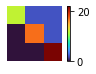

#### Simplified QUBO with $γ = 35$

70*x1*x2 + 70*x1*x3 - 90*x1 + 70*x2*x3 - 85*x2 - 80*x3 + 140

QUBO Matrix      Eigenvalues       Eigenvectors
---------------  ----------------  ------------------------------------
[[-90  70  70]   [-90. -85. -80.]  [[1.         0.9974587  0.99118374]
 [  0 -85  70]                      [0.         0.07124705 0.13215783]
 [  0   0 -80]]                     [0.         0.         0.00943985]]


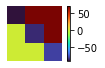

#### Simplified QUBO with $γ = 80$

160*x1*x2 + 160*x1*x3 - 225*x1 + 160*x2*x3 - 220*x2 - 215*x3 + 320

QUBO Matrix         Eigenvalues          Eigenvectors
------------------  -------------------  ------------------------------------
[[-225  160  160]   [-225. -220. -215.]  [[1.         0.99951208 0.99816671]
 [   0 -220  160]                         [0.         0.03123475 0.06049495]
 [   0    0 -215]]                        [0.         0.         0.00189047]]


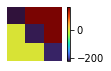

#### Simplified QUBO with $γ = 200$

400*x1*x2 + 400*x1*x3 - 585*x1 + 400*x2*x3 - 580*x2 - 575*x3 + 800

QUBO Matrix         Eigenvalues          Eigenvectors
------------------  -------------------  ------------------------------------------------
[[-585  400  400]   [-585. -580. -575.]  [[1.00000000e+00 9.99921884e-01 9.99695260e-01]
 [   0 -580  400]                         [0.00000000e+00 1.24990236e-02 2.46838336e-02]
 [   0    0 -575]]                        [0.00000000e+00 0.00000000e+00 3.08547920e-04]]


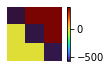

In [88]:
Q = make_qubo(γ = [1, 35, 80, 200], verbose = 1)
# for i in [1,4,40]: make_qubo(γ = i, verbose = True)

QUBO:


15*x1 + 20*x2 + 25*x3 + γ*(x1 + x2 + x3 - 2)**2

#### Simplified QUBO with $γ = 23$

46*x1*x2 + 46*x1*x3 - 54*x1 + 46*x2*x3 - 49*x2 - 44*x3 + 92

QUBO Matrix      Eigenvalues       Eigenvectors
---------------  ----------------  ------------------------------------
[[-54  46  46]   [-54. -49. -44.]  [[1.         0.99414446 0.9810992 ]
 [  0 -49  46]                      [0.         0.10805918 0.19237239]
 [  0   0 -44]]                     [0.         0.         0.02091004]]


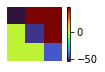

#### Simplified QUBO with $γ = 24$

48*x1*x2 + 48*x1*x3 - 57*x1 + 48*x2*x3 - 52*x2 - 47*x3 + 96

QUBO Matrix      Eigenvalues       Eigenvectors
---------------  ----------------  ------------------------------------
[[-57  48  48]   [-57. -52. -47.]  [[1.         0.99461841 0.98247844]
 [  0 -52  48]                      [0.         0.10360608 0.18537329]
 [  0   0 -47]]                     [0.         0.         0.01930972]]


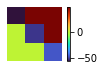

#### Simplified QUBO with $γ = 25$

50*x1*x2 + 50*x1*x3 - 60*x1 + 50*x2*x3 - 55*x2 - 50*x3 + 100

QUBO Matrix      Eigenvalues       Eigenvectors
---------------  ----------------  ------------------------------------
[[-60  50  50]   [-60. -55. -50.]  [[1.         0.99503719 0.98371253]
 [  0 -55  50]                      [0.         0.09950372 0.17885682]
 [  0   0 -50]]                     [0.         0.         0.01788568]]


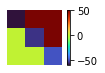

#### Simplified QUBO with $γ = 26$

52*x1*x2 + 52*x1*x3 - 63*x1 + 52*x2*x3 - 58*x2 - 53*x3 + 104

QUBO Matrix      Eigenvalues       Eigenvectors
---------------  ----------------  ------------------------------------
[[-63  52  52]   [-63. -58. -53.]  [[1.         0.99540903 0.98482109]
 [  0 -58  52]                      [0.         0.09571241 0.17277563]
 [  0   0 -53]]                     [0.         0.         0.01661304]]


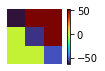

#### Simplified QUBO with $γ = 27$

54*x1*x2 + 54*x1*x3 - 66*x1 + 54*x2*x3 - 61*x2 - 56*x3 + 108

QUBO Matrix      Eigenvalues       Eigenvectors
---------------  ----------------  ------------------------------------
[[-66  54  54]   [-66. -61. -56.]  [[1.         0.99574067 0.98582056]
 [  0 -61  54]                      [0.         0.09219821 0.16708823]
 [  0   0 -56]]                     [0.         0.         0.01547113]]


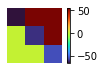

In [ ]:
Q = make_qubo(γ = [23, 24, 25, 26, 27], verbose = 1)

Calculate all possible solutions for the choosing boxes problem with 3 variables for different $γ$ :

In [ ]:
# Calcuate the QUBO for various γ
# For high γ (200) the dynamic of the hardware is not utilized

for γ in [1, 35, 50, 200]:
# for γ in [23, 24, 25, 26, 27]:
    display(Markdown(f'All possible solution values for $γ = {γ}$'))
    print(f'     x1       x2       x3  γ  {" " * len(str(γ))} x1  x2  x3')
    for x1 in [0, 1]:
        for x2 in [0, 1]:
            for x3 in [0, 1]:
                print(f'15 * {x1} + 20 * {x2} + 25 * {x3} + {γ} * ({x1} + {x2} + {x3} - 2)**2   \t= ',
                      15 * x1 + 20 * x2 + 25 * x3 + γ * (x1 + x2 + x3 - 2)**2)

All possible solution values for $γ = 1$

     x1       x2       x3  γ    x1  x2  x3
15 * 0 + 20 * 0 + 25 * 0 + 1 * (0 + 0 + 0 - 2)**2   	=  4
15 * 0 + 20 * 0 + 25 * 1 + 1 * (0 + 0 + 1 - 2)**2   	=  26
15 * 0 + 20 * 1 + 25 * 0 + 1 * (0 + 1 + 0 - 2)**2   	=  21
15 * 0 + 20 * 1 + 25 * 1 + 1 * (0 + 1 + 1 - 2)**2   	=  45
15 * 1 + 20 * 0 + 25 * 0 + 1 * (1 + 0 + 0 - 2)**2   	=  16
15 * 1 + 20 * 0 + 25 * 1 + 1 * (1 + 0 + 1 - 2)**2   	=  40
15 * 1 + 20 * 1 + 25 * 0 + 1 * (1 + 1 + 0 - 2)**2   	=  35
15 * 1 + 20 * 1 + 25 * 1 + 1 * (1 + 1 + 1 - 2)**2   	=  61


All possible solution values for $γ = 35$

     x1       x2       x3  γ     x1  x2  x3
15 * 0 + 20 * 0 + 25 * 0 + 35 * (0 + 0 + 0 - 2)**2   	=  140
15 * 0 + 20 * 0 + 25 * 1 + 35 * (0 + 0 + 1 - 2)**2   	=  60
15 * 0 + 20 * 1 + 25 * 0 + 35 * (0 + 1 + 0 - 2)**2   	=  55
15 * 0 + 20 * 1 + 25 * 1 + 35 * (0 + 1 + 1 - 2)**2   	=  45
15 * 1 + 20 * 0 + 25 * 0 + 35 * (1 + 0 + 0 - 2)**2   	=  50
15 * 1 + 20 * 0 + 25 * 1 + 35 * (1 + 0 + 1 - 2)**2   	=  40
15 * 1 + 20 * 1 + 25 * 0 + 35 * (1 + 1 + 0 - 2)**2   	=  35
15 * 1 + 20 * 1 + 25 * 1 + 35 * (1 + 1 + 1 - 2)**2   	=  95


All possible solution values for $γ = 50$

     x1       x2       x3  γ     x1  x2  x3
15 * 0 + 20 * 0 + 25 * 0 + 50 * (0 + 0 + 0 - 2)**2   	=  200
15 * 0 + 20 * 0 + 25 * 1 + 50 * (0 + 0 + 1 - 2)**2   	=  75
15 * 0 + 20 * 1 + 25 * 0 + 50 * (0 + 1 + 0 - 2)**2   	=  70
15 * 0 + 20 * 1 + 25 * 1 + 50 * (0 + 1 + 1 - 2)**2   	=  45
15 * 1 + 20 * 0 + 25 * 0 + 50 * (1 + 0 + 0 - 2)**2   	=  65
15 * 1 + 20 * 0 + 25 * 1 + 50 * (1 + 0 + 1 - 2)**2   	=  40
15 * 1 + 20 * 1 + 25 * 0 + 50 * (1 + 1 + 0 - 2)**2   	=  35
15 * 1 + 20 * 1 + 25 * 1 + 50 * (1 + 1 + 1 - 2)**2   	=  110


All possible solution values for $γ = 200$

     x1       x2       x3  γ      x1  x2  x3
15 * 0 + 20 * 0 + 25 * 0 + 200 * (0 + 0 + 0 - 2)**2   	=  800
15 * 0 + 20 * 0 + 25 * 1 + 200 * (0 + 0 + 1 - 2)**2   	=  225
15 * 0 + 20 * 1 + 25 * 0 + 200 * (0 + 1 + 0 - 2)**2   	=  220
15 * 0 + 20 * 1 + 25 * 1 + 200 * (0 + 1 + 1 - 2)**2   	=  45
15 * 1 + 20 * 0 + 25 * 0 + 200 * (1 + 0 + 0 - 2)**2   	=  215
15 * 1 + 20 * 0 + 25 * 1 + 200 * (1 + 0 + 1 - 2)**2   	=  40
15 * 1 + 20 * 1 + 25 * 0 + 200 * (1 + 1 + 0 - 2)**2   	=  35
15 * 1 + 20 * 1 + 25 * 1 + 200 * (1 + 1 + 1 - 2)**2   	=  260


Here again all possible solutions are shown, including the duplicate counts of the results per $γ$ :

In [96]:
# Calcuate the QUBO for various γ
# Note: for γ in [5, 10, 15, 20, 25, 30] there are duplicate solutions

num_vars = 3
γs = [22, 23, 24, 25, 26, 27]
γs = [1, 10, 20, 21, 22, 23, 24, 25, 26, 27, 35, 40, 80, 200][:-2]
# γs = [5, 10, 15, 20, 25, 30]  # duplicates
# γs = range(2100)

# vars_combs = np.array(sorted(np.array(np.meshgrid(*([[0, 1]] * num_vars))).reshape(-1, num_vars).tolist()))
vars_combs = np.array([[int(b) for b in ("0" * num_vars + bin(x)[2:])[-num_vars:]] for x in range(2 ** num_vars)])
vars_combs = {f'x{k}': v for k, v in zip(range(1, num_vars + 1), vars_combs.T)}

df = pd.DataFrame(vars_combs)
df2 = pd.Series([γs] * len(df), name = "γ", index = df.index)
df = df.join(df2.explode()).set_index("γ", append = True).swaplevel(0, 1, axis = 0).sort_index()

df["|"] = "|"
df["15"] = ""
df["* x1"] = df.x1
df["+ 20"] = ""
df["* x2"] = df.x2
df["+ 25"] = ""
df["* x3"] = df.x3
df["+ γ"] = df.index.get_level_values(0)
df["(x1"] = df.x1
df["+ x2"] = df.x2
df["+ x3"] = df.x3
df["- 2"] = "" #2
df[")^2"] = ""
df["="] = ""
df["result"] = 15 * df.x1 + 20 * df.x2 + 25 * df.x3 + df.index.get_level_values(0) * (df.x1 + df.x2 + df.x3 - 2)**2
# df["Equation"] = "15 * " + df.x1.astype(str) + " + 20 * {df.x2} + 25 * {df.x3} + {γ} * ({df.x1} + {df.x2} + {df.x3} - 2)**2"
df["duplicates"] = df.groupby(level = "γ", axis = 0).apply(lambda x: x.duplicated(subset = "result", keep = False)).values

# df_dups = df.duplicates.groupby(level = 0).sum()
df_dups = df.duplicates.groupby(level = "γ").sum()
display(df_dups[df_dups != 0].to_frame().rename(columns = {"duplicates": "Duplicate_count"}))
# display(df.result.groupby(level = "γ").agg(["min", "max", "var", "std", "mean", "median", "sem", "sum", "skew", np.ptp]).style.bar())

display(
    df.style.bar(
        subset = ["result"],
        color = "#ff92a585",
    ).set_properties(
        **{"background-color": "#adadad69"},
        subset = pd.IndexSlice[pd.IndexSlice[df.index.unique(level = 0)[::2], :], :]
    ).text_gradient(
        subset = [c for c in df.columns if any([x in c for x in ["x1", "x2", "x3"]]) and c not in ["x1", "x2", "x3"]],
        cmap = "bwr_r",  # tab10 PiYG
    ).text_gradient(
        subset = "duplicates",
        cmap = "bwr",
    )
)

,Duplicate_count
γ,
10,4
20,8
25,4


In [90]:
def make_Q_dict(Q: np.ndarray, verbose = False) -> dict:
    """
    Prepare the Q matrix for DWaveSampler()
    """
    Q = Q.astype(float)  # for nan masking
    if verbose:
        pprint(Q)

    triu_indices = np.triu_indices(Q.shape[0])
    # triu_indices = np.dstack(triu_indices)[0]

    mask = np.ones_like(Q).astype(bool)
    mask[triu_indices] = False

    assert np.isnan(Q[mask]).all() or (Q[mask] == 0).all(), "Lower triangle should not contain any values"

    # set lower triangle to np.nan
    Q[mask] = np.nan

    Q_dict = {k: v for (k, v) in np.ndenumerate(Q) if not np.isnan(v)}

    if verbose:
        pprint(Q_dict)
    return Q_dict


Q = make_Q_dict(make_qubo(γ = 40, verbose = False), verbose = True)
# for i in [1,4,40]: make_Q_dict(make_qubo(γ = i, verbose = False), verbose = True)

array([[-105.,   80.,   80.],
       [   0., -100.,   80.],
       [   0.,    0.,  -95.]])
{(0, 0): -105.0,
 (0, 1): 80.0,
 (0, 2): 80.0,
 (1, 1): -100.0,
 (1, 2): 80.0,
 (2, 2): -95.0}


### Run Problem on D-Wave QA

In [91]:
Q = make_Q_dict(make_qubo(γ = 35))

sampler = EmbeddingComposite(DWaveSampler())

# Create a bqm object...
bqm = dimod.BQM.from_qubo(Q)
sampleset = sampler.sample(bqm, num_reads = 10, label = f'Choosing Boxes QUBO (γ = {γ})')

# ...or use sample_qubo() directly.
# sampleset = sampler.sample_qubo(Q, num_reads = 10)

Note that the energies returned by the QA are negative here, unlike in the solutions above.

In [7]:
print(sampleset, end = "\n\n")
pprint(vars(sampleset)); print()
# sampleset

   0  1  2 energy num_oc. chain_.
0  1  1  0 -105.0       6     0.0
1  1  0  1 -100.0       2     0.0
2  0  1  1  -95.0       1     0.0
3  1  0  0  -90.0       1     0.0
['BINARY', 4 rows, 10 samples, 3 variables]

{'_info': {'problem_id': 'ae49c94b-c722-43a9-8bda-cc538266031e',
           'timing': {'post_processing_overhead_time': 764.0,
                      'qpu_access_overhead_time': 20109.2,
                      'qpu_access_time': 9285.8,
                      'qpu_anneal_time_per_sample': 20.0,
                      'qpu_delay_time_per_sample': 20.54,
                      'qpu_programming_time': 8448.6,
                      'qpu_readout_time_per_sample': 43.18,
                      'qpu_sampling_time': 837.2,
                      'total_post_processing_time': 764.0}},
 '_record': rec.array([([1, 1, 0], -105., 6, 0.), ([1, 0, 1], -100., 2, 0.),
           ([0, 1, 1],  -95., 1, 0.), ([1, 0, 0],  -90., 1, 0.)],
          dtype=[('sample', 'i1', (3,)), ('energy', '<f8'), ('num_

### Lagrange Multiplier (γ) Comparison

Note that the energies are not scaled here.

In [ ]:
samplesets = {}

# for γ in [23, 24, 25, 26, 27]:
# for γ in reversed([23, 24, 25, 26, 27]):
for γ in [1, 10, 20, 30, 35, 40, 60, 80, 100, 120, 150, 200]:

    sampler = EmbeddingComposite(DWaveSampler())

    # x1, x2, x3 = [dimod.Binary(f'x{i}') for i in range(1, 4)]
    # bqm = 15 * x1 + 20 * x2 + 25 * x3 + γ * (x1 + x2 + x3 - 2)**2
    # sampleset = sampler.sample(bqm, num_reads = 100)

    Q = make_Q_dict(make_qubo(γ = γ))
    sampleset = sampler.sample_qubo(Q, num_reads = 100, label = f'Choosing Boxes (γ = {γ})')

    # print(f'>>>   γ = {γ}   <<<\n{sampleset}\n')
    samplesets[γ] = sampleset

In [ ]:
df = pd.concat({γ: s.to_pandas_dataframe() for γ, s in samplesets.items()}).rename_axis(index = ["γ", "#"])
df = df.convert_dtypes()
df = df.rename(columns = {0: "x1", 1: "x2", 2: "x3"})

df["result"] = df["x1"] * 15 + df["x2"] * 20 + df["x3"] * 25  # summed weight
df["#picked"] = df["x1"] + df["x2"] + df["x3"]  # number of picked boxes (constraint)

display(
    df.style.bar(
        subset = ["chain_break_fraction", "energy", "num_occurrences"],
        color = "#ff92a585",
    ).set_properties(
        **{"background-color": "#adadad69"},  # #004ba752
        subset = pd.IndexSlice[pd.IndexSlice[df.index.unique(level = 0)[::2], :], :]
    ).background_gradient(
        subset = "result",
        cmap = "Blues_r"
    ).set_properties(
        subset = "#picked",
        **{"font-weight": "bold"}
    ).text_gradient(
        subset = "#picked",
        cmap = "tab10"
    )
)

Note: Changing the order of the γ's or inserting a pause in between seems to have quite an impact on the outcome. Maybe `num_reads = 100` is also not sufficient.

# Single Qubit Problem

Here it should be shown if the Quantum Annealer by D-Wave exclusively finds the correct solution for all trials.

In [4]:
γ = 1
x1 = dimod.Binary("x1")

bqm = x1 #+ γ * (x1 - 1)**2
bqm

BinaryQuadraticModel({'x1': 1.0}, {}, 0.0, 'BINARY')

In [5]:
sampler_bqm = EmbeddingComposite(DWaveSampler())
sampleset_bqm = sampler_bqm.sample(bqm, num_reads = 10_000, label = "Trivial 1-Qubit Problem")

display(sampleset_bqm.to_pandas_dataframe())
print(str(sampleset_bqm).splitlines()[-1])

,x1,chain_break_fraction,energy,num_occurrences
0,0,0.0,0.0,10000


['BINARY', 1 rows, 10000 samples, 1 variables]


In [32]:
pd.DataFrame.from_dict(sampleset_bqm.info["timing"], orient = "index", columns = ["time [μs]"])

,time [μs]
qpu_sampling_time,716000.00
qpu_anneal_time_per_sample,20.00
qpu_readout_time_per_sample,31.06
qpu_access_time,724447.40
qpu_access_overhead_time,9581.60
qpu_programming_time,8447.40
qpu_delay_time_per_sample,20.54
total_post_processing_time,548.00
post_processing_overhead_time,548.00


The Exact Solver shows all possible solutions:

In [108]:
sampleset_bqm_exact = dimod.ExactSolver().sample(bqm)
# sampleset_bqm_exact = dimod.ExactDQMSolver().sample_dqm(bqm)
# sampleset_bqm_exact = dimod.ExactPolySolver().sample(bqm)

qvars = bqm.variables.to_serializable()
sampleset_bqm_exact_df = sampleset_bqm_exact.to_pandas_dataframe()
# sampleset_bqm_exact_df["constraint_satisfied"] = sampleset_bqm_exact_df.loc[:, qvars].sum(axis = 1) == 0
display(sampleset_bqm_exact_df.sort_values(by = "energy"))
# display(sampleset_bqm_exact_df.sort_values(by = qvars))
print(str(sampleset_bqm_exact).splitlines()[-1])

,x1,energy,num_occurrences
0,0,0.0,1
1,1,1.0,1


['BINARY', 2 rows, 2 samples, 1 variables]
